<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Deep Learning for NLP
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
    <font color=orange>II - 2 </font>
  Sequence to Sequence
  </div> 

  <div style="
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px;">
    a. Machine Translation
  </div> 

  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  Jean-baptiste AUJOGUE
  </div> 

### Part I

1. Word Embedding

2. Sentence Classification

3. Language Modeling

4. Sequence Labelling


### Part II

1. Text Classification

2. <font color=orange>**Sequence to sequence**</font>


### Part III

8. Abstractive Summarization

9. Question Answering

10. Chatbot


</div>

***

<a id="plan"></a>

| | | | |
|------|------|------|------|
| **Content** | [Corpus](#corpus) | [Modules](#modules) | [Model](#model) | 

We consider here Machine Translation between English and French. Many corpuses can be found at :

- http://opus.nlpl.eu/ (most important)
- http://www.statmt.org/
- https://www.statmt.org/wmt15/translation-task.html
- http://casmacat.eu/corpus/global-voices.html
- http://www.statmt.org/europarl/

Highly optimized repos towards Seq2Seq tasks :
- [openNMT](https://github.com/OpenNMT/OpenNMT-py) with paper [OpenNMT: Open-Source Toolkit for Neural Machine Translation (2017)](https://arxiv.org/pdf/1701.02810.pdf)
- [AllenNLP](https://github.com/allenai/allennlp) with paper [AllenNLP: A Deep Semantic Natural Language Processing Platform (2018)](https://arxiv.org/pdf/1803.07640.pdf)
- [Fairseq](https://github.com/pytorch/fairseq)  with paper [Fairseq: A Fast, Extensible Toolkit for Sequence Modeling (2019)](https://arxiv.org/pdf/1904.01038.pdf)

Other influential repos :

- [sgrvinod](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Machine-Translation/blob/master/model.py)

A paper describing the state of NMT as of 2020 is [A Survey of Deep Learning Techniques for Neural Machine Translation (2020)](https://arxiv.org/pdf/2002.07526.pdf)

# Packages

In [1]:
from __future__ import unicode_literals, print_function, division

import sys
import warnings
import os
from io import open
import unicodedata
import string
import json
import time
import math
import re
import random
import pickle
import copy
from unidecode import unidecode
import itertools
import matplotlib
import matplotlib.pyplot as plt


# for special math operation
from sklearn.preprocessing import normalize


# for manipulating data 
import numpy as np
#np.set_printoptions(threshold=np.nan)
import pandas as pd
import bcolz # see https://bcolz.readthedocs.io/en/latest/intro.html
import pickle


# for text processing
import gensim
from gensim.models import KeyedVectors
import nltk
#nltk.download()
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import spacy

# for deep learning
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

warnings.filterwarnings("ignore")
print('python version :', sys.version)
print('pytorch version :', torch.__version__)
print('DL device :', device)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


python version : 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
pytorch version : 1.5.0
DL device : cuda


In [2]:
path_to_DL4NLP = os.path.dirname(os.getcwd())
path_to_data   = 'D:\\data'

In [3]:
sys.path.append(path_to_DL4NLP + '\\lib')

<a id="corpus"></a>

# Corpus

[Back to top](#plan)

Le texte est importé et mis sous forme de liste, où chaque élément représente un texte présenté sous forme d'une liste de mots.

In [4]:
# data 1
with open(path_to_data + '\\english-french translation\\kaggle1\\small_vocab_en.csv', encoding = 'utf8') as f : corpus1_en = f.readlines()
with open(path_to_data + '\\english-french translation\\kaggle1\\small_vocab_fr.csv', encoding = 'utf8') as f : corpus1_fr = f.readlines()

In [5]:
print(len(corpus1_en), len(corpus1_fr))

137860 137860


In [6]:
# data 2
# plusieurs versions fr correspondant à une seule phrase en.
# donc plus approprié pour fr -> en
with open(path_to_data + '\\english-french translation\\ankiweb\\fr_en.txt', encoding = 'utf8') as f : corpus2 = f.readlines()
    
corpus2 = [s.split('\t') for
           s in corpus2]
corpus2_en = [s[0] for s in corpus2]
corpus2_fr = [s[1] for s in corpus2]

In [7]:
print(len(corpus2_en), len(corpus2_fr))

145437 145437


In [8]:
# data 3
df = np.load(path_to_data + '\\english-french translation\\kaggle3\\data.npz')
with open(path_to_data + '\\english-french translation\\kaggle3\\inp_lang.json')  as json_file: lang0 = json.load(json_file)
with open(path_to_data + '\\english-french translation\\kaggle3\\targ_lang.json') as json_file: lang1 = json.load(json_file)

In [9]:
infos_en = json.loads(lang0)
infos_fr = json.loads(lang1)

index2word_en = json.loads(infos_en['config']['index_word'])
index2word_fr = json.loads(infos_fr['config']['index_word'])

index2word_en['1'] = 'UNK'
index2word_en['2'] = 'SOS'
index2word_en['3'] = 'EOS'

index2word_fr['1'] = 'SOS'
index2word_fr['2'] = 'EOS'
#word2index_en = json.loads(infos_en['config']['word_index'])
#word2index_fr = json.loads(infos_fr['config']['word_index'])

In [10]:
print(list(index2word_en.items())[:5])
print(list(index2word_fr.items())[:5])

[('1', 'UNK'), ('2', 'SOS'), ('3', 'EOS'), ('4', 'i'), ('5', 'the')]
[('1', 'SOS'), ('2', 'EOS'), ('3', 'je'), ('4', 'de'), ('5', 'pas')]


In [11]:
data = [df[f] for f in df.files]

In [12]:
corpus3_en = [' '.join([index2word_en[str(i)] for i in s if i > 3]) for s in data[0]]
corpus3_fr = [' '.join([index2word_fr[str(i)] for i in s if i > 2]) for s in data[1]]

In [13]:
print(corpus3_en[10], '\n', corpus3_fr[10])

i lost 
 j'ai perdu


In [14]:
print(len(corpus3_en), len(corpus3_fr))

121935 121935


In [15]:
# not implemented
# plusieurs versions fr correspondant à une seule phrase en.
# donc plus approprié pour fr -> en
#df = pd.read_excel(path_to_data + '\\english-french translation\\kaggle2\\eng-french.xlsx', header = 0, encoding = 'unicode')

In [16]:
# not implemented
# de mauvaise qualité donc inutilisé
#with open(path_to_data + '\\english-french translation\\commoncrawl\\commoncrawl.fr-en.en', encoding = 'utf8') as f : corpus4_en = f.readlines()
#with open(path_to_data + '\\english-french translation\\commoncrawl\\commoncrawl.fr-en.fr', encoding = 'utf8') as f : corpus4_fr = f.readlines()

In [17]:
# data 4
with open(path_to_data + '\\english-french translation\\IWSLT 2017 evaluation campaign fr-en\\train.tags.fr-en.en', encoding = 'utf8') as f : corpus4_en = f.readlines()
with open(path_to_data + '\\english-french translation\\IWSLT 2017 evaluation campaign fr-en\\train.tags.fr-en.fr', encoding = 'utf8') as f : corpus4_fr = f.readlines()

In [18]:
html_indices = [i for i, s in enumerate(corpus4_en) if s.startswith('<')]
corpus4_en = [s for i, s in enumerate(corpus4_en) if i not in html_indices]
corpus4_fr = [s for i, s in enumerate(corpus4_fr) if i not in html_indices]

In [19]:
print(len(corpus4_en), len(corpus4_fr)) 
# 232825

232825 232825


#### $\bullet$ Fusion of all corpuses

In [20]:
corpus_en = corpus1_en + corpus2_en + corpus3_en + corpus4_en
corpus_fr = corpus1_fr + corpus2_fr + corpus3_fr + corpus4_fr

In [21]:
print(len(corpus_en), len(corpus_fr))

638057 638057


In [22]:
print(corpus_en[11],'\n', corpus_fr[11])

he saw a old yellow truck .
 
 il a vu un vieux camion jaune .



In [23]:
print(corpus_en[280000], '\n',corpus_fr[280000])

What kind of music did you listen to when you were a teenager? 
 Quelle sorte de musique écoutais-tu lorsque tu étais adolescent ?



In [24]:
print(corpus_en[-255],'\n', corpus_fr[-255])

Cristina had worked for four years with my sister and the quality of her work was well-established. 
 
  Cristina avait travaillé avec ma sœur pendant 4 ans et la qualité de son travail était bien établie.



In [26]:
def tokenize(s) :
    words = word_tokenize(s)
    words = [w.lower() for w in words]
    return words

def tokenize2(en, fr) :
    def replace(w, copies) :
        if w in copies :
            # if w has at least one num and has no letter
            if re.sub('[0-9]', '', w) != w and re.sub('[a-zA-Z]', '', w) == w : return 'NUM'
            # if first letter is upper case
            elif w[0].isupper() : return 'PROPN'
        return w.lower()
    en, fr = word_tokenize(en), word_tokenize(fr)
    copies = np.unique([w for w in en if w in fr])
    en = [replace(w, copies) for w in en]
    fr = [replace(w, copies) for w in fr]
    return (en, fr)

def keep(en, fr) :
    return (0 < len(en) < 25 and 0 < len(fr) < 25) # and len(intersect(en, fr)) <= 3)

Avoid sentences with more than 25 words :

In [27]:
#en_fr = [[tokenize(en), tokenize(fr)] for en, fr in zip(corpus_en, corpus_fr)]
#en_fr = [[en, fr] for en, fr in en_fr if keep(en, fr)]

In [28]:
en_fr = [tokenize2(en, fr) for en, fr in zip(corpus_en, corpus_fr)]
en_fr = [[en, fr] for en, fr in en_fr if keep(en, fr)]

In [29]:
fr_en = [[p[1], p[0]] for p in en_fr]

In [30]:
len(en_fr)

562611

In [31]:
copies = [w for s in en_fr for w in s[0] if w in s[1]]
copies = np.unique(copies)

In [32]:
len(copies)

4588

<a id="modules"></a>

# 1 Modules

### 1.1 Word Embedding module

[Back to top](#plan)

We consider here a FastText model trained following the Skip-Gram training objective.

In [4]:
from libDL4NLP.models.Word_Embedding import Word2Vec as myWord2Vec
from libDL4NLP.models.Word_Embedding import Word2VecConnector
from libDL4NLP.utils.Lang import Lang

In [5]:
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile

**Option 1** : Load pretrained

In [6]:
# load
#word2vec_en = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en.model"))
#word2vec_fr = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr.model"))

word2vec_en_xl = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en_xl.model"))
word2vec_fr_xl = FastText.load(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr_xl.model"))

**Option 2** : Train new model

In [109]:
corpus_in  = [['SOS'] + s[0] + ['EOS'] for s in fr_en]
corpus_out = [['SOS'] + s[1] + ['EOS'] for s in fr_en]

In [110]:
word2vec_fr = FastText(
    size = 200,
    window = 5, 
    min_count = 2, 
    negative = 15,
    sg = 1)

In [111]:
word2vec_fr.build_vocab(corpus_in)
print(len(word2vec_fr.wv.vocab))

40862


In [118]:
word2vec_fr.train(sentences = corpus_in, 
                  epochs = 50,
                  total_examples = word2vec_fr.corpus_count)

In [116]:
word2vec_en = FastText(size = 200, 
                        window = 5, 
                        min_count = 1, 
                        negative = 15,
                        sg = 1)

In [117]:
word2vec_en.build_vocab(corpus_out)
print(len(word2vec_en.wv.vocab))

39805


In [119]:
word2vec_en.train(sentences = corpus_out, 
                  epochs = 50,
                  total_examples = word2vec_en.corpus_count)

In [120]:
# save
#word2vec_en.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_en_xl.model"))
#word2vec_fr.save(get_tmpfile(path_to_DL4NLP + "\\saves\\DL4NLP_II2a_w2v_fr_xl.model"))

### 1.2 Contextualization module

[Back to top](#plan)

This module consists of a bi-directional _Gated Recurrent Unit_ (GRU) that supports packed sentences :

In [7]:
from libDL4NLP.modules import RecurrentEncoder

### 1.3 Attention module

[Back to top](#plan)

<a id="attention"></a>

We use here a classical Attention Module :

In [8]:
from libDL4NLP.modules import Attention

### 1.4 Decoder module

[Back to top](#plan)

<a id="decoder"></a>

#### 1.4.1 Vanilla Decoder

In [ ]:
#from libDL4NLP.modules import Decoder

In [9]:
class Decoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, hid_dim, 
                 n_layer = 1,
                 dropout = 0.1,
                 bound   = 25
                ):
        super().__init__()
        
        # relevant quantities
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.bound   = bound
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.out_dim,
            hid_dim, 
            n_layer, 
            dropout = dropout, 
            batch_first = True)
        
        self.out = nn.Linear(
            hid_dim, 
            word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)     # size (batch_size, 1)
        word = Variable(word)                               # size (batch_size, 1)
        if device is not None : word = word.to(device)      # size (batch_size, 1)
        return word
        
        
    def generateWord(self, hidden, word):
        '''word is a LongTensor with size (batch_size, 1)'''
        embedding = self.word2vec.embedding(word)       # size (batch_size, 1, emb_dim)
        embedding = self.dropout(embedding)             # size (batch_size, 1, emb_dim)
        _, hidden = self.gru(embedding, hidden)         # size (n_layer, batch_size, emb_dim)
        vect      = self.out(hidden[-1])                # size (batch_size, lang_size)
        return vect, hidden
    
    
    def forward(self, hidden, device = None) :
        answer = []
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layer:]              # size (n_layer, 1, hid_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word proba
            vect, hidden = self.generateWord(hidden, word)
            # compute next word index
            word_index = vect.topk(1, dim = 1)[1].item()
            # stopping criterion
            if word_index == EOS_token : break
            else : 
                answer.append(word_index)
                word = vect.topk(1, dim = 1)[1].view(1, 1)
        return answer

#### 1.4.2 Decoder with Attention

Decoder with an Attention mechanism, that reads over input words and select most salient words at each decoding step. This idea is proposed in [Effective Approaches to Attention-based Neural Machine Translation
 (2015)](https://arxiv.org/pdf/1508.04025.pdf).

In [ ]:
#from libDL4NLP.modules import AttnDecoder

In [10]:
class AttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attn_dim, hid_dim,
                 n_layer = 1,
                 attn_method = 'concat',
                 dropout = 0.1,
                 bound   = 25,
                 temperature = 1,
                 top = None
                ):
        super().__init__()
        
        # relevant quantities
        self.attn_dim = attn_dim
        self.hid_dim  = hid_dim
        self.n_layer  = n_layer
        self.method   = attn_method
        self.bound    = bound
        self.temp     = temperature
        self.top      = top
        
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.out_dim,
            hid_dim, 
            n_layer, 
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            emb_dim   = attn_dim, 
            query_dim = hid_dim, 
            method    = attn_method,
            dropout   = dropout)
        
        self.out = nn.Linear(attn_dim + hid_dim, word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)       # size (batch_size, 1)
        word = Variable(word)                                 # size (batch_size, 1)
        if device is not None : word = word.to(device)        # size (batch_size, 1)
        return word
        
        
    def generateWord(self, hidden, word, embeddings, lengths = None):
        '''word is a LongTensor with size (batch_size, 1)'''
        # update hidden state
        embedding = self.word2vec.embedding(word)             # size (batch_size, 1, emb_dim)
        embedding = self.dropout(embedding)                   # size (batch_size, 1, emb_dim)
        _, hidden = self.gru(embedding, hidden)               # size (n_layer, batch_size, hid_dim)
        # compute attention
        query = self.dropout(hidden[-1].unsqueeze(1))         # size (batch_size, 1, hid_dim)
        attn, weights = self.attn(embeddings, query, lengths) # size (batch_size, 1, attn_dim)
        # merge hidden with attention
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                           # size (batch_size, hid_dim + attn_dim)
        # generate next word
        vect = self.out(merge)                                # size (batch_size, lang_size)
        return (vect, hidden, weights)
    

    def computeProba(self, vect, device = None):
        '''Converts a word repartition vector with size (batch_size, lang_size)
           into a probability vector with size (batch_size, lang_size)'''
        # apply temperature
        vect /= self.temp
        # top-p proba refactoring
        if type(self.top) == float and 0 < self.top < 1 : 
            # TODO
            proba = F.softmax(vect, dim = 1)
        #top-k proba refactoring
        elif type(self.top) == int and self.top > 0 : 
            vals, inds = vect.topk(self.top, dim = 1)        # size (batch_size, self.top)
            proba_vals = F.softmax(vals, dim = 1)            # size (batch_size, self.top)
            proba = torch.FloatTensor(vect.size()).zero_()
            if device is not None : proba = proba.to(device)
            proba.scatter_(1, inds, proba_vals)              # size (batch_size, lang_size)
        # vanilla softmax
        else :
            proba = F.softmax(vect, dim = 1)
        return proba
    
    
    def sampleWord(self, proba) :
        '''Selects word indices out of a probability distribution over vocab'''
        # choose best
        word = proba.topk(1, dim = 1)[1] 
        # random sampling
        # TODO
        return word
    
    
    def forward(self, hidden, embeddings, lengths = None, device = None) :
        answer  = []
        weights = None
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        hidden    = hidden[-self.n_layer:]             # size (n_layer, 1, hid_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word
            vect, hidden, attn = self.generateWord(hidden, word, embeddings, lengths)
            proba = self.computeProba(vect, device)
            word  = self.sampleWord(proba)
            # cumulate word and attention weight
            if word.item() != EOS_token :
                answer.append(word.item())
                if t == 0 : weights = attn
                else      : weights = torch.cat((weights, attn), dim = 1) # size(1, out_length, in_length)
            # stopping criterion
            else : break
        return (answer, weights)

#### 1.4.3 Decoder with Smoothed Past Token Feeding

An Attention Decoder being a smooth function of the encode-to-decode hidden vector. This idea was presented in [Differentiable Scheduled Sampling for Credit Assignment (2017)](https://arxiv.org/pdf/1704.06970.pdf). This makes the model struggle to learn, and does not lead to any improvement. To make a compromise between feeding the _single generated token_ or _full word probability_ computed during previous token generation, we propose to pass as input a word probability refactored on top-k words, with k an hyperparameter. k = 1 corresponds to feeding the past generated token, whereas k = vocab_size yields de full probability feed. This is inspired from top-k sampling and top-p sampling presented in [The Curious Case of Neural Text Degeneration (2019)](https://arxiv.org/pdf/1904.09751.pdf). 

This latter idea yielded better results than fully smooth decoder, but counldn't compete with the previous attention decoder.

In [ ]:
#from libDL4NLP.modules import SmoothAttnDecoder

In [11]:
class SmoothAttnDecoder(nn.Module):
    '''
    Converts a vector into a sequence of words,
    where next token prediction is based on previous token probability distribution
    rather than previous token selection
    '''
    def __init__(self, word2vec, attn_dim, hid_dim,
                 n_layer = 1,
                 attn_method = 'concat',
                 dropout = 0.1,
                 bound   = 25,
                 temperature = 1,
                 top = None
                ):
        super().__init__()
        
        # relevant quantities
        lang_size, emb_dim = word2vec.embedding.weight.size()
        self.lang_size = lang_size
        self.emb_dim   = emb_dim
        self.attn_dim  = attn_dim
        self.hid_dim   = hid_dim
        self.n_layer   = n_layer
        self.method    = attn_method
        self.bound     = bound
        self.temp      = temperature
        self.top       = top
        
        # modules
        # dense embedding with shared weights
        self.embedding = nn.Linear(lang_size, emb_dim, bias = False)
        self.embedding.weight.data = word2vec.embedding.weight.data.t()
        for param in self.embedding.parameters() : param.requires_grad = False
            
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            emb_dim,
            hid_dim,
            n_layer,
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            emb_dim   = attn_dim, 
            query_dim = hid_dim, 
            method    = attn_method,
            dropout   = dropout)
        
        self.out = nn.Linear(attn_dim + hid_dim, lang_size)

        self.act = F.log_softmax
        self.dropout = nn.Dropout(dropout)

        
    def initWordTensor(self, index_list, device = None) :
        '''converts a list of N word indices with vocab of size L
           into a dense FloatTensor of size (N, L)'''
        word = torch.zeros((len(index_list), self.lang_size), dtype = torch.float)
        for i, index in enumerate(index_list) : word[i, index] = 1.
        word = Variable(word)                                 # size (batch_size, lang_size)
        if device is not None : word = word.to(device)        # size (batch_size, lang_size)
        return word
        
        
    def generateWord(self, hidden, word, embeddings, lengths = None):
        '''word is a FloatTensor with size (batch_size, lang_size)'''
        # update hidden state
        embedding = self.embedding(word.unsqueeze(1))         # size (batch_size, 1, emb_dim)
        embedding = self.dropout(embedding)                   # size (batch_size, 1, emb_dim)
        _, hidden  = self.gru(embedding, hidden)              # size (n_layer, batch_size, hid_dim)
        # compute attention
        query = self.dropout(hidden[-1].unsqueeze(1))         # size (batch_size, 1, hid_dim)
        attn, weights = self.attn(embeddings, query, lengths) # size (batch_size, 1, attn_dim)
        # merge hidden with attention
        merge = torch.cat([hidden[-1], attn.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                           # size (batch_size, hid_dim + attn_dim)
        # generate next word
        vect = self.out(merge)                                # size (batch_size, lang_size)
        return (vect, hidden, weights)
    
    
    def computeProba(self, vect, device = None):
        '''Converts a word repartition vector with size (batch_size, lang_size)
           into a probability vector with size (batch_size, lang_size)'''
        # apply temperature
        vect /= self.temp
        # top-p proba refactoring
        if type(self.top) == float and 0 < self.top < 1 : 
            # TODO
            proba = F.softmax(vect, dim = 1)
        #top-k proba refactoring
        elif type(self.top) == int and self.top > 0 : 
            vals, inds = vect.topk(self.top, dim = 1)        # size (batch_size, self.top)
            proba_vals = F.softmax(vals, dim = 1)            # size (batch_size, self.top)
            proba = torch.FloatTensor(vect.size()).zero_()
            if device is not None : proba = proba.to(device)
            proba.scatter_(1, inds, proba_vals)              # size (batch_size, lang_size)
        # vanilla softmax
        else :
            proba = F.softmax(vect, dim = 1)
        return proba
    
    
    def sampleWord(self, proba) :
        '''Selects word indices out of a probability distribution over vocab'''
        # choose best
        word = proba.topk(1, dim = 1)[1] 
        # random sampling
        # TODO
        return word
    
    
    def forward(self, hidden, embeddings, lengths = None, device = None) :
        answer  = []
        weights = None
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        proba     = self.initWordTensor([SOS_token], device = device) 
        hidden    = hidden[-self.n_layer:]                 # size (n_layer, 1, hid_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word
            vect, hidden, attn = self.generateWord(hidden, proba, embeddings, lengths)
            proba = self.computeProba(vect, device)
            word  = self.sampleWord(proba)
            # cumulate word and attention weight
            if word.item() != EOS_token :
                answer.append(word.item())
                if t == 0 : weights = attn
                else      : weights = torch.cat((weights, attn), dim = 1) # size(1, out_length, in_length)
            # stopping criterion
            else : break
        return (answer, weights)

#### 1.4.4 Decoder with Content-based Past Attention Feeding

A variant of the Attention Decoder with feeding of past attention, as proposed in [Effective Approaches to Attention-based Neural Machine Translation (2015)](https://arxiv.org/pdf/1508.04025.pdf), in order to feed the decoder with _**content-based**_ past attention before next token generation.

In [ ]:
#from libDL4NLP.modules import PAFAttnDecoder

In [12]:
class PAFAttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attn_dim, hid_dim,
                 n_layer = 1,
                 attn_method = 'concat',
                 dropout = 0.1,
                 bound   = 25,
                 temperature = 1,
                 top = None
                ):
        super().__init__()
        
        # relevant quantities
        self.attn_dim = attn_dim
        self.hid_dim  = hid_dim
        self.n_layer  = n_layer
        self.method   = attn_method
        self.bound    = bound
        self.temp     = temperature
        self.top      = top
        
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.out_dim + attn_dim,
            hid_dim, 
            n_layer, 
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            emb_dim   = attn_dim, 
            query_dim = hid_dim, 
            method    = attn_method,
            dropout   = dropout)
        
        self.out = nn.Linear(hid_dim + attn_dim, word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)       # size (batch_size, 1)
        word = Variable(word)                                 # size (batch_size, 1)
        if device is not None : word = word.to(device)        # size (batch_size, 1)
        return word
        
    
    def initContext(self, batch_size) :
        return torch.zeros((batch_size, 1, self.attn_dim), dtype = torch.float)
        
    
    def generateWord(self, hidden, word, context, embeddings, lengths = None):
        '''word is a LongTensor with size (batch_size, 1)'''
        # merge previous word with previous attention
        embedding = self.word2vec.embedding(word)             # size (batch_size, 1, emb_dim)
        embedding = self.dropout(embedding)                   # size (batch_size, 1, emb_dim)
        context   = self.dropout(context)                     # size (batch_size, 1, attn_dim)
        embedding = torch.cat((embedding, context), dim = 2)  # size (batch_size, 1, emb_dim + attn_dim)
        # update hidden state
        _, hidden = self.gru(embedding, hidden)               # size (n_layers, batch_size, hid_dim)
        # compute next attention
        query = self.dropout(hidden[-1].unsqueeze(1))         # size (batch_size, 1, hid_dim)
        context, attn = self.attn(embeddings, query, lengths) # size (batch_size, 1, attn_dim)
        # merge hidden with attention
        merge = torch.cat([hidden[-1], context.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                           # size (batch_size, hid_dim + attn_dim)
        # generate next word
        vect = self.out(merge)                                # size (batch_size, lang_size)
        return (vect, hidden, context, attn)
    

    def computeProba(self, vect, device = None):
        '''Converts a word repartition vector with size (batch_size, lang_size)
           into a probability vector with size (batch_size, lang_size)'''
        # apply temperature
        vect /= self.temp
        # top-p proba refactoring
        if type(self.top) == float and 0 < self.top < 1 : 
            # TODO
            proba = F.softmax(vect, dim = 1)
        #top-k proba refactoring
        elif type(self.top) == int and self.top > 0 : 
            vals, inds = vect.topk(self.top, dim = 1)        # size (batch_size, self.top)
            proba_vals = F.softmax(vals, dim = 1)            # size (batch_size, self.top)
            proba = torch.FloatTensor(vect.size()).zero_()
            if device is not None : proba = proba.to(device)
            proba.scatter_(1, inds, proba_vals)              # size (batch_size, lang_size)
        # vanilla softmax
        else :
            proba = F.softmax(vect, dim = 1)
        return proba
    
    
    def sampleWord(self, proba) :
        '''Selects word indices out of a probability distribution over vocab'''
        # choose best
        word = proba.topk(1, dim = 1)[1] 
        # random sampling
        # TODO
        return word
    
    
    def forward(self, hidden, embeddings, lengths = None, device = None) :
        answer  = []
        weights = None
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        context   = self.initContext(1)
        hidden    = hidden[-self.n_layer:]             # size (n_layer, 1, hid_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word
            vect, hidden, context, attn = self.generateWord(hidden, word, context, embeddings, lengths)
            proba = self.computeProba(vect, device)
            word  = self.sampleWord(proba)
            # cumulate word and attention weight
            if word.item() != EOS_token :
                answer.append(word.item())
                if t == 0 : weights = attn
                else      : weights = torch.cat((weights, attn), dim = 1) # size(1, out_length, in_length)
            # stopping criterion
            else : break
        return (answer, weights)

#### 1.4.5 Decoder with Position-based Past Attention Feeding

Our implementation of the Attention Decoder with feeding of _**past coverage**_ , as proposed in (at least)

- [Incorporating Structural Alignment Biases into an Attentional Neural Translation Model (2016)](https://arxiv.org/pdf/1601.01085.pdf)
- [Modeling Coverage for Neural Machine Translation (2016)](https://arxiv.org/pdf/1601.04811.pdf)
- [Get To The Point: Summarization with Pointer-Generator Networks (2017)](https://arxiv.org/pdf/1704.04368.pdf)

in order to feed the decoder with _**position-based**_ past attention before next token generation.

In [ ]:
#from libDL4NLP.modules import CovAttnDecoder

In [13]:
class CovAttnDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, word2vec, attn_dim, hid_dim,
                 n_layer = 1,
                 attn_method = 'concat',
                 dropout = 0.1,
                 bound   = 25,
                 temperature = 1,
                 top = None
                ):
        super().__init__()
        
        # relevant quantities
        self.attn_dim = attn_dim
        self.hid_dim  = hid_dim
        self.n_layer  = n_layer
        self.method   = attn_method
        self.bound    = bound
        self.temp     = temperature
        self.top      = top
        
        # modules
        self.word2vec = word2vec
        
        self.gru = nn.GRU(
            word2vec.out_dim,
            hid_dim, 
            n_layer, 
            dropout = dropout,
            batch_first = True)
        
        self.attn = Attention(
            emb_dim   = attn_dim + 1, 
            query_dim = hid_dim, 
            method    = attn_method,
            dropout   = dropout)
        
        self.out = nn.Linear(hid_dim + attn_dim, word2vec.lang.n_words)
        
        self.dropout = nn.Dropout(dropout)
    
    
    def initWordTensor(self, index_list, device = None) :
        word = torch.LongTensor(index_list).view(-1, 1)       # size (batch_size, 1)
        word = Variable(word)                                 # size (batch_size, 1)
        if device is not None : word = word.to(device)        # size (batch_size, 1)
        return word
        
    
    def initContext(self, batch_size, seq_length) :
        return torch.zeros((batch_size, seq_length, 1), dtype = torch.float)
        
    
    def generateWord(self, hidden, word, past_attn, embeddings, lengths = None):
        '''word is a LongTensor with size (batch_size, 1)'''
        # embed previous word
        embedding = self.word2vec.embedding(word)             # size (batch_size, seq_length, emb_dim)
        embedding = self.dropout(embedding)                   # size (batch_size, seq_length, emb_dim)
        # update hidden state
        _, hidden = self.gru(embedding, hidden)               # size (n_layers, batch_size, hid_dim)
        # merge embeddings with culmulated past attention
        embeddings = torch.cat((embeddings, past_attn), dim = 2)# size (batch_size, seq_length, emb_dim + 1)
        # compute next attention
        query   = self.dropout(hidden[-1].unsqueeze(1))       # size (batch_size, 1, hid_dim)
        context, attn = self.attn(embeddings, query, lengths) # size (batch_size, 1, attn_dim) | (batch_size, 1, emb_length)
        #avoid cumulated past attention
        context = context[:, :, :-1] 
        # update cumulated past attention
        past_attn += attn.transpose(1, 2)
        # merge hidden with attention
        merge = torch.cat([hidden[-1], context.squeeze(1)], dim = 1) 
        merge = self.dropout(merge)                           # size (batch_size, hid_dim + attn_dim)
        # generate next word
        vect = self.out(merge)                                # size (batch_size, lang_size)
        return (vect, hidden, past_attn, attn)
    

    def computeProba(self, vect, device = None):
        '''Converts a word repartition vector with size (batch_size, lang_size)
           into a probability vector with size (batch_size, lang_size)'''
        # apply temperature
        vect /= self.temp
        # top-p proba refactoring
        if type(self.top) == float and 0 < self.top < 1 : 
            # TODO
            proba = F.softmax(vect, dim = 1)
        #top-k proba refactoring
        elif type(self.top) == int and self.top > 0 : 
            vals, inds = vect.topk(self.top, dim = 1)        # size (batch_size, self.top)
            proba_vals = F.softmax(vals, dim = 1)            # size (batch_size, self.top)
            proba = torch.FloatTensor(vect.size()).zero_()
            if device is not None : proba = proba.to(device)
            proba.scatter_(1, inds, proba_vals)              # size (batch_size, lang_size)
        # vanilla softmax
        else :
            proba = F.softmax(vect, dim = 1)
        return proba
    
    
    def sampleWord(self, proba) :
        '''Selects word indices out of a probability distribution over vocab'''
        # choose best
        word = proba.topk(1, dim = 1)[1] 
        # random sampling
        # TODO
        return word
    
    
    def forward(self, hidden, embeddings, lengths = None, device = None) :
        answer  = []
        weights = None
        EOS_token = self.word2vec.lang.getIndex('EOS')
        SOS_token = self.word2vec.lang.getIndex('SOS')
        word      = self.initWordTensor([SOS_token], device = device)
        context   = self.initContext(1, embeddings.size(1))
        hidden    = hidden[-self.n_layer:]             # size (n_layer, 1, hid_dim)
        # word generation
        for t in range(self.bound) :
            # compute next word
            vect, hidden, context, attn = self.generateWord(hidden, word, context, embeddings, lengths)
            proba = self.computeProba(vect, device)
            word  = self.sampleWord(proba)
            # cumulate word and attention weight
            if word.item() != EOS_token :
                answer.append(word.item())
                if t == 0 : weights = attn
                else      : weights = torch.cat((weights, attn), dim = 1) # size(1, out_length, in_length)
            # stopping criterion
            else : break
        return (answer, weights)

#### Visualisation of attention

Taken from [this page](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py)

In [14]:
from libDL4NLP.utils import AttentionViewer, AttentionViewerOnWords

<a id="model"></a>

# 2 Encoder-Decoder Model

[Back to top](#plan)


In [ ]:
#from libDL4NLP.models import EncoderDecoder

In [15]:
class EncoderDecoder(nn.Module) :
    def __init__(
        self, device, tokenizer, word2vec_in, word2vec_out,
        detokenizer = None,
        hid_dim_in = 50,
        hid_dim_out = 50,
        n_layer_in = 1,
        n_layer_out = 1,
        bound = 25,
        dropout = 0,
        decoder_warm_start = True,
        attn_type = 'standard',
        attn_method = 'concat',
        optimizer = optim.SGD,
        ):
        
        super().__init__()
        #relevant quantities
        self.decoder_warm_start = decoder_warm_start
        self.attn_type = attn_type
        
        # text processing
        self.tokenizer    = tokenizer
        self.detokenizer  = detokenizer
        
        # modules
        self.word2vec_in  = word2vec_in
        self.word2vec_out = word2vec_out
        
        self.context      = RecurrentEncoder(
            emb_dim       = word2vec_in.out_dim,
            hid_dim       = hid_dim_in,
            n_layer       = n_layer_in,
            dropout       = dropout, 
            bidirectional = True)
            
        if self.attn_type == 'standard' : 
            self.decoder    = AttnDecoder(
                word2vec    = word2vec_out, 
                attn_dim    = hid_dim_in, 
                hid_dim     = hid_dim_out, 
                n_layer     = n_layer_out,
                attn_method = attn_method,
                dropout     = dropout, 
                bound       = bound)

        elif self.attn_type == 'smooth' : 
            self.decoder    = SmoothAttnDecoder(
                word2vec    = word2vec_out, 
                attn_dim    = hid_dim_in, 
                hid_dim     = hid_dim_out, 
                n_layer     = n_layer_out, 
                attn_method = attn_method,
                dropout     = dropout, 
                bound       = bound,
                top         = 5)
            
        elif self.attn_type == 'paf' : 
            self.decoder    = PAFAttnDecoder(
                word2vec    = word2vec_out, 
                attn_dim    = hid_dim_in, 
                hid_dim     = hid_dim_out, 
                n_layer     = n_layer_out,
                attn_method = attn_method,
                dropout     = dropout, 
                bound       = bound)
            
        elif self.attn_type == 'cov' : 
            self.decoder    = CovAttnDecoder(
                word2vec    = word2vec_out, 
                attn_dim    = hid_dim_in, 
                hid_dim     = hid_dim_out, 
                n_layer     = n_layer_out,
                attn_method = attn_method,
                dropout     = dropout, 
                bound       = bound)
            
        else : 
            self.decoder = Decoder(
                word2vec = word2vec_out,  
                hid_dim  = hid_dim_out, 
                n_layer  = n_layer_out, 
                dropout  = dropout, 
                bound    = bound)
        
        # optimizer
        self.ignore_index_in  = self.word2vec_in.lang.getIndex('PADDING_WORD')
        self.ignore_index_out = self.word2vec_out.lang.getIndex('PADDING_WORD')
        self.criterion = nn.NLLLoss(size_average = False, ignore_index = self.ignore_index_out)
        self.optimizer = optimizer
        
        # load to device
        self.device = device
        self.to(device)
        
        
    # count parameters
    def nbParametres(self) :
        return sum([p.data.nelement() for p in self.parameters() if p.requires_grad == True])
    
    
    # main method
    def forward(self, sentence, mask_unk = True, attention_method = None):
        # encode sentence
        words_native, words_in = self.tokenizer(sentence)
        if mask_unk :
            words_in   = [w for w in words_in if self.word2vec_in.lang.getIndex(w) is not None]
            indices    = [self.word2vec_in.lang.getIndex(w) for w in words_in]
            embeddings = Variable(torch.LongTensor([indices])).to(self.device)
            embeddings = self.word2vec_in.embedding(embeddings)
        else :
            embeddings = self.word2vec_in(words_in, self.device)
        embeddings, hidden  = self.context(embeddings)
        # prepare for decoding
        if self.decoder_warm_start :
            if self.context.bidirectional :
                hidden = hidden.view(self.context.n_layer, 2, -1, self.context.hid_dim)
                hidden = torch.sum(hidden, dim = 1) # size (n_layer, batch_size, hid_dim)
            hidden = hidden[-self.decoder.n_layer:]
        else : hidden = None    
        # compute answer
        if self.attn_type in ['standard', 'smooth', 'paf', 'cov'] : 
            indices, attn = self.decoder(hidden, embeddings, device = self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
            attn = np.array(attn[0].data.cpu().numpy()) # size (out_length, in_length)
            # detokenize generic tokens
            if self.detokenizer is not None :
                words_out = self.detokenizer(words_out, words_native, attn)
            # display attention
            if attention_method is not None : 
                attention_method(attn, words_out, words_native)
        else :
            indices   = self.decoder(hidden, device = self.device)
            words_out = [self.word2vec_out.lang.index2word[i] for i in indices]
        # convert answer to string
        answer = ' '.join(words_out)
        return answer

    
    # load data
    def generatePackedSentences(self, sentences, batch_size = 32) : 
        '''forms minibatches of sentences, where input sentences must be pre-tokenized'''
        sentences.sort(key = lambda s: len(s[1]), reverse = True)
        packed_data = []
        for i in range(0, len(sentences), batch_size) :
            # prepare input and target pack
            pack = sentences[i:i + batch_size]
            pack.sort(key = lambda s: len(s[0]), reverse = True)
            pack0 = [[self.word2vec_in.lang.getIndex(w) for w in qa[0]] for qa in pack]
            pack0 = [[w for w in words if w is not None] for words in pack0]
            pack1 = [[self.word2vec_out.lang.getIndex(w) for w in qa[1] + ['EOS']] for qa in pack]
            pack1 = [[w for w in words if w is not None] for words in pack1]
            lengths0 = torch.tensor([len(p) for p in pack0])           # size (batch_size) 
            lengths1 = torch.tensor([len(p) for p in pack1])           # size (batch_size) 
            # padd packs
            pack0 = list(itertools.zip_longest(*pack0, fillvalue = self.ignore_index_in))
            pack0 = Variable(torch.LongTensor(pack0).transpose(0, 1)) # size (batch_size, max_length_in) 
            pack1 = list(itertools.zip_longest(*pack1, fillvalue = self.ignore_index_out))
            pack1 = Variable(torch.LongTensor(pack1))       # WARNING : size (max_length_out, batch_size) 
            packed_data.append([pack0, lengths0, pack1, lengths1])
        return packed_data
    
    
    # compute model perf
    def compute_accuracy(self, sentences, batch_size = 32) :
        def compute_batch_accuracy(batch) :
            torch.cuda.empty_cache()
            input, input_l, target, target_l = batch
            lengths = input_l.to(self.device)
            target  = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden = self.context(embeddings, lengths) # size (n_layer * num_directions, batch_size, hid_dim)
            # prepare for decoding
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layer, 2, -1, self.context.hid_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layer, batch_size, hid_dim)
                hidden = hidden[-self.decoder.n_layer:]
            else : hidden = None  
            # init decoder states
            answers   = torch.zeros(target.size(), dtype = torch.long)
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            if self.attn_type == 'paf'  : context = self.decoder.initContext(input.size(0)).to(self.device)
            if self.attn_type == 'cov'  : context = self.decoder.initContext(input.size(0), input.size(1)).to(self.device)
            # compute answers
            for t in range(target.size(0)) :
                # feeds most probable word at previous step as input for next word prediction
                if self.attn_type == 'standard' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, word, embeddings, lengths)
                    proba = self.decoder.computeProba(vect) # size (batch_size, lang_size)
                    best  = self.decoder.sampleWord(proba)  # size (batch_size, 1)
                    word  = best
                # feeds word proba at previous step as input for next word prediction
                elif self.attn_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, word, embeddings, lengths)
                    proba = self.decoder.computeProba(vect) # size (batch_size, lang_size)
                    best  = self.decoder.sampleWord(proba)   # size (batch_size, 1)
                    word  = proba
                # feeds most probable word at previous step and past attention as input for next word prediction
                elif self.attn_type in ['paf', 'cov'] :
                    vect, hidden, context, attn = self.decoder.generateWord(hidden, word, context, embeddings, lengths)
                    proba = self.decoder.computeProba(vect) # size (batch_size, lang_size)
                    best  = self.decoder.sampleWord(proba)  # size (batch_size, 1)
                    word  = best
                # feeds most probable word at previous step as input for next word prediction
                else :
                    vect, hidden = self.decoder.generateWord(hidden, word)
                    word = vect.topk(1, dim = 1)[1]   # size (batch_size, 1)
                    best = word                       # size (batch_size, 1)
                answers[t] = best.view(-1)
            # compute score
            score = sum([sum(answers[:l, i].data.cpu() == target[:l, i].data.cpu()) == l 
                          for i, l in enumerate(target_l.data.cpu().tolist())]).item()
            return score
        
        # -- main --
        batches = self.generatePackedSentences(sentences, batch_size)
        score = 0
        for batch in batches : score += compute_batch_accuracy(batch)
        return score * 100 / len(sentences)
    
    
    # fit model
    def fit(self, batches, iters = None, epochs = None, tf_ratio = 0, lr = 0.025, random_state = 42,
            print_every = 10, compute_accuracy = True):
        """Performs training over a given dataset and along a specified amount of loops"""
        def asMinutes(s):
            m = math.floor(s / 60)
            s -= m * 60
            return '%dm %ds' % (m, s)
        
        def timeSince(since, percent):
            now = time.time()
            s = now - since
            rs = s/percent - s
            return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
        
        def computeSuccess(log_prob, targets) :
            success = sum([self.ignore_index_out != targets[i].item() == log_prob[i].topk(1)[1].item() \
                           for i in range(targets.size(0))])
            return success
        
        def computeLogProbs(batch, tf_ratio = 0, compute_accuracy = True) :
            torch.cuda.empty_cache()
            loss = 0
            success = 0
            forcing = (random.random() < tf_ratio)
            input, input_l, target, target_l = batch
            lengths = input_l.to(self.device)
            target  = target.to(self.device)
            # encode sentences
            embeddings = self.word2vec_in.embedding(input.to(self.device))
            embeddings, hidden  = self.context(embeddings, lengths) # size (n_layer * num_directions, batch_size, hid_dim)
            # init decoder state
            if self.decoder_warm_start :
                if self.context.bidirectional :
                    hidden = hidden.view(self.context.n_layer, 2, -1, self.context.hid_dim)
                    hidden = torch.sum(hidden, dim = 1) # size (n_layer, batch_size, hid_dim)
                hidden = hidden[-self.decoder.n_layer:]
            else : hidden = None  
            # init decoder states
            SOS_token = self.word2vec_out.lang.getIndex('SOS')
            word      = self.decoder.initWordTensor([SOS_token]*target.size(1), device = self.device) 
            if self.attn_type == 'paf'  : context = self.decoder.initContext(input.size(0)).to(self.device)
            if self.attn_type == 'cov'  : context = self.decoder.initContext(input.size(0), input.size(1)).to(self.device)
            # decode answers
            for t in range(target.size(0)) :
                # feeds word proba at previous step as input for next word prediction
                if self.attn_type == 'standard' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, word, embeddings, lengths)
                    if forcing : word  = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word  = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                # feeds word proba at previous step as input for next word prediction        
                elif self.attn_type == 'smooth' :
                    vect, hidden, attn = self.decoder.generateWord(hidden, word, embeddings, lengths)
                    if forcing : word  = self.decoder.initWordTensor(target[t].data.tolist(), device = self.device) # size (batch_size, 1) 
                    else       : word  = self.decoder.computeProba(vect) # size (batch_size, lang_size)
                # feeds most probable word at previous step and past attention as input for next word prediction
                elif self.attn_type in ['paf', 'cov'] :
                    vect, hidden, context, attn = self.decoder.generateWord(hidden, word, context, embeddings, lengths)
                    if forcing : word  = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word  = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                # feeds most probable word at previous step as input for next word prediction
                else :
                    vect, hidden      = self.decoder.generateWord(hidden, word)
                    if forcing : word = target[t].view(-1, 1)    # size (batch_size, 1) 
                    else       : word = vect.topk(1, dim = 1)[1] # size (batch_size, 1)
                # cumulate loss
                log_prob = F.log_softmax(vect, dim = 1)
                loss += self.criterion(log_prob, target[t])
                if compute_accuracy : success += computeSuccess(log_prob, target[t])
            return loss, success
        
        def printScores(start, iter, iters, tot_loss, tot_loss_words, print_every, compute_accuracy) :
            avg_loss = tot_loss / print_every
            avg_loss_words = tot_loss_words / print_every
            if compute_accuracy : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}  accuracy : {:.1f} %'.format(iter, int(iter / iters * 100), avg_loss, avg_loss_words))
            else                : print(timeSince(start, iter / iters) + ' ({} {}%) loss : {:.3f}                     '.format(iter, int(iter / iters * 100), avg_loss))
            return 0, 0
        
        def trainLoop(batch, optimizer, tf_ratio = 0, compute_accuracy = True):
            """Performs a training loop, with forward pass, backward pass and weight update"""
            optimizer.zero_grad()
            self.zero_grad()
            total = torch.sum(batch[-1]).item()
            loss, success = computeLogProbs(batch, tf_ratio, compute_accuracy)
            loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), 5.)
            optimizer.step()
            return float(loss.item() / total), float(success * 100 / total)
        
        # --- main ---
        self.train()
        random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in self.parameters() if param.requires_grad == True], lr = lr)
        tot_loss = 0  
        tot_acc  = 0
        if epochs is None :
            for iter in range(1, iters + 1):
                batch = random.choice(batches)
                loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                tot_loss += loss
                tot_acc += acc      
                if iter % print_every == 0 : 
                    tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        else :
            iter = 0
            iters = len(batches) * epochs
            for epoch in range(1, epochs + 1):
                print('epoch ' + str(epoch))
                np.random.shuffle(batches)
                for batch in batches :
                    loss, acc = trainLoop(batch, optimizer, tf_ratio, compute_accuracy)
                    tot_loss += loss
                    tot_acc += acc 
                    iter += 1
                    if iter % print_every == 0 : 
                        tot_loss, tot_acc = printScores(start, iter, iters, tot_loss, tot_acc, print_every, compute_accuracy)
        return


#### Model Tokenizer

In [16]:
def model_tokenize(s, lang_in) :
    def replace(w) :
        if w.lower() not in lang_in.word2index :
            # if w has at least one num and has no letter
            if re.sub('[0-9]', '', w) != w and re.sub('[a-zA-Z]', '', w) == w : return 'NUM'
            # if first letter is upper case
            elif w[0].isupper() : return 'PROPN'
        return w.lower()
    words_native = word_tokenize(s)
    words = [replace(w) for w in words_native]
    return words_native, words


def model_detokenize(words_out, words_native, attn) :
    # attn : 2D numpy array of size (len_words_out, len_words_in)
    words_detok = []
    bests = np.argmax(attn, axis = 1) # size (len_words_out)
    for i, w in enumerate(words_out) :
        if w in ['PROPN', 'NUM'] : words_detok.append(words_native[bests[i]])
        else                     : words_detok.append(w)
    return words_detok

#### Training

Model training should be completed after 3 epochs using the following training procedure :


In [ ]:
# batch size = 32
#translator_fr_en.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.75, print_every = 25, random_state = 42)
#translator_fr_en.fit(batches, epochs = 1, lr = 0.0001, tf_ratio = 0.75, print_every = 25, random_state = 421)
#translator_fr_en.fit(batches, epochs = 1, lr = 0.000025, tf_ratio = 0.75, print_every = 25, random_state = 42142)

In [ ]:
word2vec_in  = Word2VecConnector(word2vec_fr_xl)
word2vec_out = Word2VecConnector(word2vec_en_xl)

translator_fr_en_xl = EncoderDecoder(
    device = torch.device("cpu"),                   
    tokenizer = lambda s : model_tokenize(s, word2vec_in.lang),
    detokenizer = model_detokenize,
    word2vec_in = word2vec_in,
    word2vec_out = word2vec_out,
    hid_dim_in = 400,
    hid_dim_out = 400,
    n_layer_in = 2,
    n_layer_out = 2,
    bound = 25,
    dropout = 0.1,
    decoder_warm_start = True,
    attn_type = 'cov', # [None, 'standard', 'smooth', 'paf', 'cov']
    attn_method = 'concat', # ['dot', 'general', 'concat']
    optimizer = optim.AdamW)

translator_fr_en_xl.nbParametres()

In [18]:
translator_fr_en_xl.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth'))

<All keys matched successfully>

In [47]:
batches = translator_fr_en_xl.generatePackedSentences(fr_en, batch_size = 64)
len(batches)

8791

In [135]:
translator_fr_en_xl.fit(batches, epochs = 1, lr = 0.001, tf_ratio = 0.75, print_every = 25, random_state = 42)

epoch 1
2m 36s (- 916m 2s) (25 0%) loss : 7.153  accuracy : 10.0 %
5m 20s (- 933m 48s) (50 0%) loss : 5.759  accuracy : 11.4 %
7m 47s (- 905m 38s) (75 0%) loss : 5.599  accuracy : 13.2 %
10m 29s (- 911m 15s) (100 1%) loss : 5.363  accuracy : 14.1 %
13m 2s (- 904m 22s) (125 1%) loss : 5.345  accuracy : 18.0 %
15m 25s (- 888m 25s) (150 1%) loss : 5.008  accuracy : 18.3 %
17m 43s (- 872m 50s) (175 1%) loss : 5.239  accuracy : 21.6 %
20m 38s (- 886m 39s) (200 2%) loss : 5.048  accuracy : 21.0 %
22m 58s (- 874m 23s) (225 2%) loss : 4.939  accuracy : 23.2 %
25m 17s (- 864m 19s) (250 2%) loss : 4.486  accuracy : 28.4 %
27m 52s (- 863m 17s) (275 3%) loss : 4.267  accuracy : 31.7 %
30m 41s (- 868m 39s) (300 3%) loss : 4.387  accuracy : 29.9 %
33m 5s (- 861m 52s) (325 3%) loss : 4.091  accuracy : 32.8 %
35m 34s (- 857m 56s) (350 3%) loss : 4.238  accuracy : 31.7 %
38m 6s (- 855m 4s) (375 4%) loss : 3.658  accuracy : 37.9 %
40m 17s (- 845m 17s) (400 4%) loss : 3.840  accuracy : 38.9 %
42m 48s (- 

335m 32s (- 572m 4s) (3250 36%) loss : 1.630  accuracy : 69.2 %
337m 48s (- 568m 58s) (3275 37%) loss : 1.911  accuracy : 66.2 %
340m 1s (- 565m 46s) (3300 37%) loss : 1.934  accuracy : 65.0 %
342m 9s (- 562m 28s) (3325 37%) loss : 1.654  accuracy : 69.5 %
344m 20s (- 559m 16s) (3350 38%) loss : 1.977  accuracy : 65.0 %
346m 31s (- 556m 4s) (3375 38%) loss : 1.746  accuracy : 66.8 %
348m 54s (- 553m 13s) (3400 38%) loss : 1.644  accuracy : 69.6 %
351m 25s (- 550m 35s) (3425 38%) loss : 1.950  accuracy : 65.9 %
354m 6s (- 548m 12s) (3450 39%) loss : 1.366  accuracy : 73.5 %
356m 30s (- 545m 22s) (3475 39%) loss : 1.689  accuracy : 68.3 %
358m 33s (- 542m 2s) (3500 39%) loss : 2.127  accuracy : 62.5 %
360m 53s (- 539m 8s) (3525 40%) loss : 1.432  accuracy : 71.9 %
363m 37s (- 536m 49s) (3550 40%) loss : 1.968  accuracy : 65.6 %
366m 18s (- 534m 27s) (3575 40%) loss : 1.639  accuracy : 69.5 %
369m 0s (- 532m 5s) (3600 40%) loss : 2.052  accuracy : 63.9 %
371m 30s (- 529m 25s) (3625 41%) l

648m 37s (- 238m 51s) (6425 73%) loss : 1.716  accuracy : 69.5 %
650m 50s (- 236m 13s) (6450 73%) loss : 1.319  accuracy : 74.1 %
653m 53s (- 233m 53s) (6475 73%) loss : 1.531  accuracy : 71.4 %
656m 23s (- 231m 21s) (6500 73%) loss : 1.570  accuracy : 72.1 %
659m 4s (- 228m 52s) (6525 74%) loss : 1.230  accuracy : 77.2 %
661m 9s (- 226m 12s) (6550 74%) loss : 1.460  accuracy : 71.9 %
663m 50s (- 223m 44s) (6575 74%) loss : 1.372  accuracy : 74.1 %
666m 17s (- 221m 11s) (6600 75%) loss : 1.117  accuracy : 78.1 %
669m 23s (- 218m 51s) (6625 75%) loss : 1.195  accuracy : 78.5 %
671m 58s (- 216m 20s) (6650 75%) loss : 1.601  accuracy : 69.6 %
674m 38s (- 213m 51s) (6675 75%) loss : 2.070  accuracy : 64.6 %
677m 7s (- 211m 19s) (6700 76%) loss : 1.412  accuracy : 73.3 %
679m 35s (- 208m 46s) (6725 76%) loss : 1.411  accuracy : 73.5 %
682m 35s (- 206m 23s) (6750 76%) loss : 2.096  accuracy : 62.6 %
685m 21s (- 203m 56s) (6775 77%) loss : 1.405  accuracy : 73.0 %
688m 19s (- 201m 32s) (6800 

In [136]:
torch.save(translator_fr_en_xl.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth')

In [48]:
translator_fr_en_xl.fit(batches, epochs = 1, lr = 0.0001, tf_ratio = 0.75, print_every = 25, random_state = 421)

epoch 1
2m 34s (- 901m 12s) (25 0%) loss : 1.455  accuracy : 71.5 %
5m 34s (- 975m 20s) (50 0%) loss : 1.429  accuracy : 72.0 %
7m 54s (- 918m 51s) (75 0%) loss : 1.360  accuracy : 72.8 %
10m 27s (- 908m 53s) (100 1%) loss : 1.165  accuracy : 76.6 %
12m 32s (- 869m 35s) (125 1%) loss : 1.383  accuracy : 72.3 %
14m 53s (- 858m 0s) (150 1%) loss : 1.237  accuracy : 76.8 %
17m 36s (- 867m 1s) (175 1%) loss : 1.141  accuracy : 77.4 %
19m 59s (- 858m 40s) (200 2%) loss : 1.090  accuracy : 77.7 %
22m 29s (- 856m 17s) (225 2%) loss : 1.509  accuracy : 70.7 %
25m 0s (- 854m 34s) (250 2%) loss : 0.922  accuracy : 81.3 %
26m 59s (- 835m 53s) (275 3%) loss : 0.930  accuracy : 80.8 %
29m 31s (- 835m 45s) (300 3%) loss : 1.459  accuracy : 72.5 %
31m 52s (- 830m 6s) (325 3%) loss : 1.142  accuracy : 77.5 %
34m 19s (- 827m 55s) (350 3%) loss : 0.699  accuracy : 84.4 %
37m 11s (- 834m 46s) (375 4%) loss : 1.323  accuracy : 74.6 %
39m 47s (- 834m 34s) (400 4%) loss : 1.418  accuracy : 73.0 %
42m 50s (-

327m 23s (- 558m 10s) (3250 36%) loss : 1.047  accuracy : 79.9 %
329m 50s (- 555m 31s) (3275 37%) loss : 1.264  accuracy : 75.6 %
332m 17s (- 552m 54s) (3300 37%) loss : 1.333  accuracy : 74.4 %
335m 14s (- 551m 6s) (3325 37%) loss : 1.042  accuracy : 79.5 %
337m 39s (- 548m 25s) (3350 38%) loss : 1.159  accuracy : 76.9 %
340m 3s (- 545m 42s) (3375 38%) loss : 1.672  accuracy : 69.0 %
342m 48s (- 543m 32s) (3400 38%) loss : 1.562  accuracy : 70.4 %
345m 26s (- 541m 12s) (3425 38%) loss : 1.382  accuracy : 74.4 %
348m 8s (- 538m 57s) (3450 39%) loss : 0.824  accuracy : 82.7 %
350m 33s (- 536m 16s) (3475 39%) loss : 1.409  accuracy : 73.3 %
353m 14s (- 533m 59s) (3500 39%) loss : 1.220  accuracy : 76.4 %
355m 51s (- 531m 36s) (3525 40%) loss : 1.258  accuracy : 76.6 %
358m 22s (- 529m 5s) (3550 40%) loss : 1.207  accuracy : 76.9 %
360m 36s (- 526m 8s) (3575 40%) loss : 1.415  accuracy : 73.2 %
363m 8s (- 523m 37s) (3600 40%) loss : 1.064  accuracy : 78.7 %
365m 42s (- 521m 10s) (3625 41%

653m 21s (- 240m 35s) (6425 73%) loss : 1.126  accuracy : 77.9 %
656m 10s (- 238m 9s) (6450 73%) loss : 1.304  accuracy : 74.5 %
658m 46s (- 235m 37s) (6475 73%) loss : 1.425  accuracy : 72.8 %
661m 40s (- 233m 13s) (6500 73%) loss : 1.151  accuracy : 77.8 %
663m 58s (- 230m 35s) (6525 74%) loss : 1.047  accuracy : 79.9 %
666m 25s (- 228m 0s) (6550 74%) loss : 1.139  accuracy : 78.5 %
669m 13s (- 225m 32s) (6575 74%) loss : 1.404  accuracy : 73.7 %
671m 53s (- 223m 2s) (6600 75%) loss : 1.378  accuracy : 73.5 %
674m 9s (- 220m 24s) (6625 75%) loss : 1.076  accuracy : 78.1 %
676m 22s (- 217m 45s) (6650 75%) loss : 1.191  accuracy : 76.1 %
678m 39s (- 215m 8s) (6675 75%) loss : 1.465  accuracy : 71.9 %
681m 6s (- 212m 33s) (6700 76%) loss : 1.168  accuracy : 77.4 %
683m 34s (- 210m 0s) (6725 76%) loss : 1.078  accuracy : 79.1 %
686m 0s (- 207m 25s) (6750 76%) loss : 0.927  accuracy : 80.9 %
688m 21s (- 204m 49s) (6775 77%) loss : 0.985  accuracy : 80.3 %
690m 38s (- 202m 12s) (6800 77%) 

KeyboardInterrupt: 

In [49]:
torch.save(translator_fr_en_xl.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth')

In [69]:
translator_fr_en_xl.fit(batches, epochs = 1, lr = 0.000015, tf_ratio = 0.75, print_every = 25, random_state = 4214)

epoch 1
2m 42s (- 951m 6s) (25 0%) loss : 1.165  accuracy : 77.1 %
5m 30s (- 963m 37s) (50 0%) loss : 1.037  accuracy : 78.7 %
8m 26s (- 980m 48s) (75 0%) loss : 1.559  accuracy : 70.7 %
10m 49s (- 940m 15s) (100 1%) loss : 0.931  accuracy : 81.4 %
14m 23s (- 997m 50s) (125 1%) loss : 1.668  accuracy : 68.2 %
17m 7s (- 986m 45s) (150 1%) loss : 1.283  accuracy : 75.2 %
19m 47s (- 974m 40s) (175 1%) loss : 0.867  accuracy : 82.4 %
22m 24s (- 962m 35s) (200 2%) loss : 0.996  accuracy : 78.9 %
24m 56s (- 949m 17s) (225 2%) loss : 1.099  accuracy : 78.2 %
27m 30s (- 939m 40s) (250 2%) loss : 1.408  accuracy : 72.9 %
30m 3s (- 930m 59s) (275 3%) loss : 1.330  accuracy : 74.1 %
32m 34s (- 922m 12s) (300 3%) loss : 1.403  accuracy : 73.7 %
35m 0s (- 911m 50s) (325 3%) loss : 1.435  accuracy : 73.6 %
37m 8s (- 895m 49s) (350 3%) loss : 0.939  accuracy : 80.5 %
39m 46s (- 892m 36s) (375 4%) loss : 1.153  accuracy : 77.2 %
42m 35s (- 893m 36s) (400 4%) loss : 1.284  accuracy : 76.0 %
45m 32s (- 

333m 47s (- 569m 5s) (3250 36%) loss : 1.318  accuracy : 75.3 %
336m 8s (- 566m 9s) (3275 37%) loss : 1.561  accuracy : 70.1 %
338m 36s (- 563m 25s) (3300 37%) loss : 1.232  accuracy : 75.6 %
341m 16s (- 561m 1s) (3325 37%) loss : 1.154  accuracy : 77.9 %
343m 50s (- 558m 27s) (3350 38%) loss : 1.206  accuracy : 76.3 %
346m 34s (- 556m 9s) (3375 38%) loss : 1.107  accuracy : 78.0 %
348m 55s (- 553m 15s) (3400 38%) loss : 1.106  accuracy : 78.4 %
351m 28s (- 550m 40s) (3425 38%) loss : 1.254  accuracy : 75.2 %
353m 49s (- 547m 46s) (3450 39%) loss : 1.152  accuracy : 77.4 %
356m 44s (- 545m 45s) (3475 39%) loss : 1.490  accuracy : 72.6 %
359m 13s (- 543m 2s) (3500 39%) loss : 1.512  accuracy : 72.0 %
361m 44s (- 540m 25s) (3525 40%) loss : 1.263  accuracy : 76.3 %
364m 0s (- 537m 24s) (3550 40%) loss : 1.059  accuracy : 78.9 %
366m 26s (- 534m 39s) (3575 40%) loss : 0.991  accuracy : 80.3 %
369m 12s (- 532m 22s) (3600 40%) loss : 1.569  accuracy : 71.0 %
371m 58s (- 530m 6s) (3625 41%) 

654m 16s (- 240m 56s) (6425 73%) loss : 1.057  accuracy : 79.4 %
657m 1s (- 238m 27s) (6450 73%) loss : 0.695  accuracy : 84.6 %
659m 45s (- 235m 59s) (6475 73%) loss : 1.067  accuracy : 79.1 %
661m 59s (- 233m 19s) (6500 73%) loss : 0.944  accuracy : 80.3 %
664m 42s (- 230m 50s) (6525 74%) loss : 1.200  accuracy : 77.0 %
667m 30s (- 228m 22s) (6550 74%) loss : 1.401  accuracy : 74.0 %
670m 4s (- 225m 50s) (6575 74%) loss : 1.569  accuracy : 69.8 %
672m 39s (- 223m 18s) (6600 75%) loss : 1.114  accuracy : 77.6 %
675m 15s (- 220m 46s) (6625 75%) loss : 1.279  accuracy : 76.1 %
677m 36s (- 218m 9s) (6650 75%) loss : 0.784  accuracy : 83.8 %
680m 3s (- 215m 34s) (6675 75%) loss : 1.254  accuracy : 76.3 %
682m 28s (- 212m 59s) (6700 76%) loss : 1.256  accuracy : 75.7 %
684m 48s (- 210m 23s) (6725 76%) loss : 1.014  accuracy : 79.9 %
687m 4s (- 207m 45s) (6750 76%) loss : 0.963  accuracy : 80.6 %
689m 7s (- 205m 3s) (6775 77%) loss : 0.925  accuracy : 81.6 %
691m 46s (- 202m 32s) (6800 77%)

In [70]:
torch.save(translator_fr_en_xl.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth')

In [67]:
# save
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth')
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_paf_fr_en.pth')
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_smooth_fr_en.pth')
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_fr_en.pth')
#torch.save(translator_fr_en.state_dict(), path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth')

# load
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_fr_en.pth'))
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_paf_fr_en.pth'))
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_smooth_fr_en.pth'))
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_fr_en.pth'))
#translator_fr_en.load_state_dict(torch.load(path_to_DL4NLP + '\\saves\\DL4NLP_II2a_encoder_attndecoder_cov_xl_fr_en.pth'))

#### Evaluation

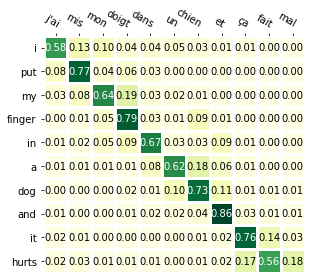

j'ai mis mon doigt dans un chien et ça fait mal  - i
j'ai mis mon doigt dans un chien et ça fait mal  - put
j'ai mis mon doigt dans un chien et ça fait mal  - my
j'ai mis mon doigt dans un chien et ça fait mal  - finger
j'ai mis mon doigt dans un chien et ça fait mal  - in
j'ai mis mon doigt dans un chien et ça fait mal  - a
j'ai mis mon doigt dans un chien et ça fait mal  - dog
j'ai mis mon doigt dans un chien et ça fait mal  - and
j'ai mis mon doigt dans un chien et ça fait mal  - it
j'ai mis mon doigt dans un chien et ça fait mal  - hurts



'i put my finger in a dog and it hurts'

In [136]:
translator_fr_en_xl.eval()
s = "j'ai mis mon doigt dans un chien et ça fait mal"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

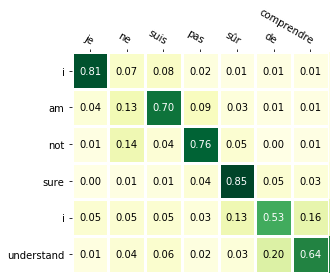

je ne suis pas sûr de comprendre  - i
je ne suis pas sûr de comprendre  - am
je ne suis pas sûr de comprendre  - not
je ne suis pas sûr de comprendre  - sure
je ne suis pas sûr de comprendre  - i
je ne suis pas sûr de comprendre  - understand



'i am not sure i understand'

In [137]:
s = "je ne suis pas sûr de comprendre"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

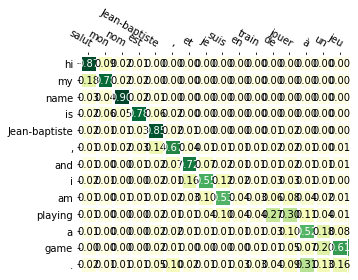

salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - hi
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - my
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - name
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - is
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - Jean-baptiste
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - ,
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - and
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - i
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - am
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - playing
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - a
salut mon nom est Jean-baptiste , et je suis en train de jouer à un jeu  - game
salut mon nom est Jean-baptiste , et je suis e

'hi my name is Jean-baptiste , and i am playing a game .'

In [19]:
translator_fr_en_xl.eval()
s = "salut mon nom est Jean-baptiste, et je suis en train de jouer à un jeu"
translator_fr_en_xl(s, mask_unk = False, attention_method = AttentionViewer)
translator_fr_en_xl(s, mask_unk = False, attention_method = AttentionViewerOnWords)

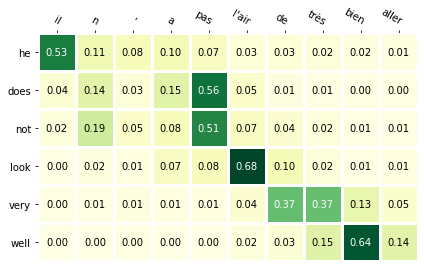

il n ' a pas l'air de très bien aller  - he
il n ' a pas l'air de très bien aller  - does
il n ' a pas l'air de très bien aller  - not
il n ' a pas l'air de très bien aller  - look
il n ' a pas l'air de très bien aller  - very
il n ' a pas l'air de très bien aller  - well



'he does not look very well'

In [140]:
translator_fr_en_xl.eval()
sentence = "il n'a pas l'air de très bien aller"
translator_fr_en_xl(sentence, attention_method = AttentionViewer)
translator_fr_en_xl(sentence, attention_method = AttentionViewerOnWords)

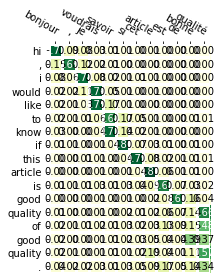

bonjour , je voudrais savoir si cet article est de bonne qualité  - hi
bonjour , je voudrais savoir si cet article est de bonne qualité  - ,
bonjour , je voudrais savoir si cet article est de bonne qualité  - i
bonjour , je voudrais savoir si cet article est de bonne qualité  - would
bonjour , je voudrais savoir si cet article est de bonne qualité  - like
bonjour , je voudrais savoir si cet article est de bonne qualité  - to
bonjour , je voudrais savoir si cet article est de bonne qualité  - know
bonjour , je voudrais savoir si cet article est de bonne qualité  - if
bonjour , je voudrais savoir si cet article est de bonne qualité  - this
bonjour , je voudrais savoir si cet article est de bonne qualité  - article
bonjour , je voudrais savoir si cet article est de bonne qualité  - is
bonjour , je voudrais savoir si cet article est de bonne qualité  - good
bonjour , je voudrais savoir si cet article est de bonne qualité  - quality
bonjour , je voudrais savoir si cet article est de bonne q

'hi , i would like to know if this article is good quality of good quality .'

In [142]:
translator_fr_en_xl.eval()
s = "bonjour, je voudrais savoir si cet article est de bonne qualité"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

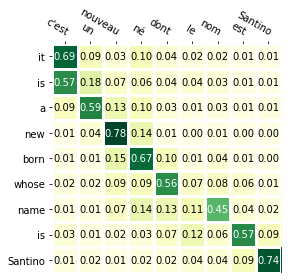

c'est un nouveau né dont le nom est Santino  - it
c'est un nouveau né dont le nom est Santino  - is
c'est un nouveau né dont le nom est Santino  - a
c'est un nouveau né dont le nom est Santino  - new
c'est un nouveau né dont le nom est Santino  - born
c'est un nouveau né dont le nom est Santino  - whose
c'est un nouveau né dont le nom est Santino  - name
c'est un nouveau né dont le nom est Santino  - is
c'est un nouveau né dont le nom est Santino  - Santino



'it is a new born whose name is Santino'

In [143]:
translator_fr_en_xl.eval()
s = "c'est un nouveau né dont le nom est Santino"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

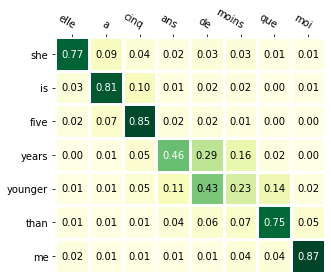

elle a cinq ans de moins que moi  - she
elle a cinq ans de moins que moi  - is
elle a cinq ans de moins que moi  - five
elle a cinq ans de moins que moi  - years
elle a cinq ans de moins que moi  - younger
elle a cinq ans de moins que moi  - than
elle a cinq ans de moins que moi  - me



'she is five years younger than me'

In [144]:
translator_fr_en_xl.eval()
s = "elle a cinq ans de moins que moi"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

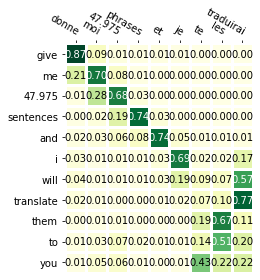

donne moi 47.975 phrases et je te les traduirai  - give
donne moi 47.975 phrases et je te les traduirai  - me
donne moi 47.975 phrases et je te les traduirai  - 47.975
donne moi 47.975 phrases et je te les traduirai  - sentences
donne moi 47.975 phrases et je te les traduirai  - and
donne moi 47.975 phrases et je te les traduirai  - i
donne moi 47.975 phrases et je te les traduirai  - will
donne moi 47.975 phrases et je te les traduirai  - translate
donne moi 47.975 phrases et je te les traduirai  - them
donne moi 47.975 phrases et je te les traduirai  - to
donne moi 47.975 phrases et je te les traduirai  - you



'give me 47.975 sentences and i will translate them to you'

In [147]:
translator_fr_en_xl.eval()
s = "donne moi 47.975 phrases et je te les traduirai"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

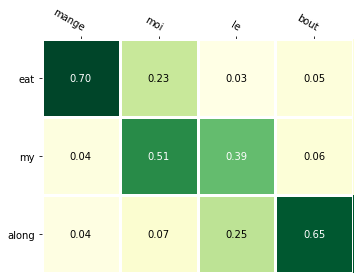

mange moi le bout  - eat
mange moi le bout  - my
mange moi le bout  - along



'eat my along'

In [25]:
translator_fr_en_xl.eval()
s = "mange moi le bout"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

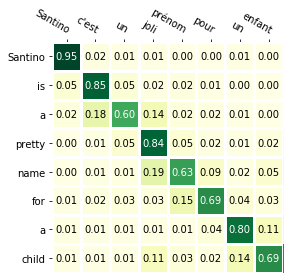

Santino c'est un joli prénom pour un enfant  - Santino
Santino c'est un joli prénom pour un enfant  - is
Santino c'est un joli prénom pour un enfant  - a
Santino c'est un joli prénom pour un enfant  - pretty
Santino c'est un joli prénom pour un enfant  - name
Santino c'est un joli prénom pour un enfant  - for
Santino c'est un joli prénom pour un enfant  - a
Santino c'est un joli prénom pour un enfant  - child



'Santino is a pretty name for a child'

In [206]:
translator_fr_en_xl.eval()
s = "Santino c'est un joli prénom pour un enfant"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)

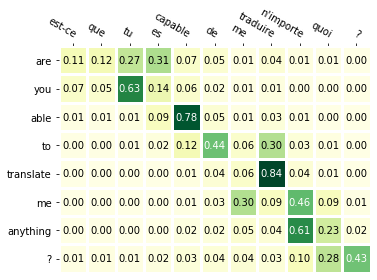

est-ce que tu es capable de me traduire n'importe quoi ?  - are
est-ce que tu es capable de me traduire n'importe quoi ?  - you
est-ce que tu es capable de me traduire n'importe quoi ?  - able
est-ce que tu es capable de me traduire n'importe quoi ?  - to
est-ce que tu es capable de me traduire n'importe quoi ?  - translate
est-ce que tu es capable de me traduire n'importe quoi ?  - me
est-ce que tu es capable de me traduire n'importe quoi ?  - anything
est-ce que tu es capable de me traduire n'importe quoi ?  - ?



'are you able to translate me anything ?'

In [213]:
translator_fr_en_xl.eval()
s = "est-ce que tu es capable de me traduire n'importe quoi ?"
translator_fr_en_xl(s, attention_method = AttentionViewer)
translator_fr_en_xl(s, attention_method = AttentionViewerOnWords)